In [1]:
# install libraries for Google Colab
!pip install --upgrade tables
!pip install eli5
!pip install ml_metrics
!pip install scikit-plot
!pip install xgboost
!pip install hyperopt

     |████████████████████████████████| 4.3MB 8.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 8.3MB/s 
  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=3d39387e6a8b51e5061cdfdbb0c21d5ec4f322e2faa98c884f1ff788eca0e80b
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [2]:
# import libraries

import pandas as pd
import numpy as np

from ml_metrics import rmsle
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, train_test_split, GridSearchCV

# import models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Optimization
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]

import scikitplot as skplt


import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


random_state=2020

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions

#### Load the data

In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd '/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution'

/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution


In [5]:
# load the wrangled and transformed data 
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df')

In [6]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,mean_PM25_nie_per_day,mean_PM25_wok_per_day,mean_PM25_nie_log_per_day,mean_PM25_wok_log_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,median_PM25_nie_per_day,median_PM25_wok_per_day,median_PM25_nie_log_per_day,median_PM25_wok_log_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,mean_PM25_nie_per_month,mean_PM25_wok_per_month,mean_PM25_nie_log_per_month,mean_PM25_wok_log_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month,median_PM25_nie_per_month,median_PM25_wok_per_month,median_PM25_nie_log_per_month,median_PM25_wok_log_per_month,PM25_nie_diff_for_day_median,PM25_nie_diff_for_day_mean,PM25_nie_diff_for_month_median,PM25_nie_diff_for_month_mean,PM25_wok_diff_for_day_median,PM25_wok_diff_for_day_mean,PM25_wok_diff_for_month_median,PM25_wok_diff_for_month_mean,Autumn,Spring,Summer,Winter,icon_num,summary_num
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,unknown,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,41.406660,37.978489,0.625938,2.070653,3.960878,3.957379,32.930000,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.930000,0.0,2.733,260.0,6.93,32.93,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.93,0.0,2.733,260.0,6.93,28.5625,0.999167,33.065,0.955,0.0,0.0,1027.802778,34.24

#### Split the data for train and test

In [7]:
# split the df for train and test, leave last 6 month for the test
train_mask = df['datetime'] < '2019-07-01'
test_mask = df['datetime'] >= '2019-07-01'

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

In [8]:
# check if the train dataset is correctly split
df_train.datetime.min(), df_train.datetime.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-06-30 23:00:00'))

In [9]:
# check if the test dataset is correctly split
df_test.datetime.min(), df_test.datetime.max()

(Timestamp('2019-07-01 00:00:00'), Timestamp('2019-12-31 23:00:00'))

#### Select original features and run simple models for benchmarking purpose

In [10]:
orig_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability', 'pressure', 'temperature',
              'uvIndex', 'visibility', 'windBearing', 'windSpeed', 'icon_num', 'summary_num']

In [41]:
# function to run different models
def run_model(feats, model, cross_val):
    X = df_train[feats].values
    y = df_train['PM25_nie_log'].values
    
    model_name = type(model).__name__

    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cross_val, scoring='neg_mean_squared_error'))
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    print("{} RMSE: {:.4f}, r2: {:.1f}%".format(model_name, np.mean(rmse), 100*np.mean(r2)))

In [42]:
# function to plot a learning curve for different models and scoring
def plot_lear_curve(feats, model, cross_val, scoring):

  X = df_train[feats].values
  y = df_train['PM25_nie_log'].values

  model_name = type(model).__name__

  skplt.estimators.plot_learning_curve(model, X, y, cv=cross_val, scoring='r2', title=f'{model_name} Learning Curve');

In [43]:
# define Cross Validation
tcsv = TimeSeriesSplit(n_splits=5)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# define simple models for fast testing
DT_model = DecisionTreeRegressor(max_depth=3, random_state=random_state)
RF_model = RandomForestRegressor(max_depth=3, random_state=random_state)
XGB_model = xgb.XGBRegressor(max_depth=3, objective='reg:squarederror', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(max_depth=3, objective='regression', random_state=random_state)

In [44]:
models = [DT_model, RF_model, XGB_model, LGBM_model]

for model in models:
    run_model(orig_feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.4983, r2: 23.5%
RandomForestRegressor RMSE: 0.4819, r2: 28.6%
XGBRegressor RMSE: 0.4593, r2: 30.8%
LGBMRegressor RMSE: 0.4569, r2: 31.9%


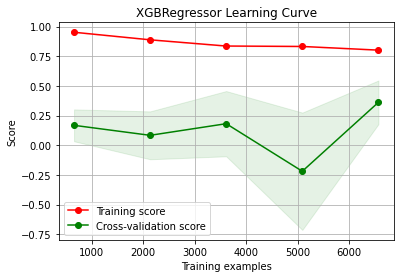

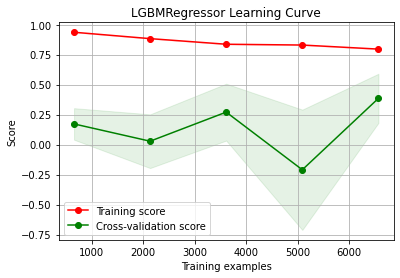

In [45]:
for model in models[2:]:
    plot_lear_curve(time_feats, model, tcsv, 'r2')

In [46]:
for model in models:
    run_model(orig_feats, model, kf)

DecisionTreeRegressor RMSE: 0.4769, r2: 39.0%
RandomForestRegressor RMSE: 0.4716, r2: 40.3%
XGBRegressor RMSE: 0.3972, r2: 57.6%
LGBMRegressor RMSE: 0.3973, r2: 57.6%


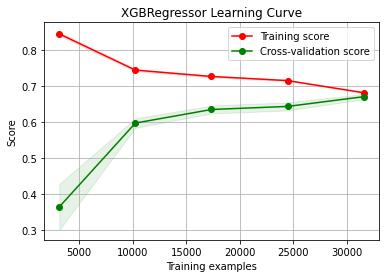

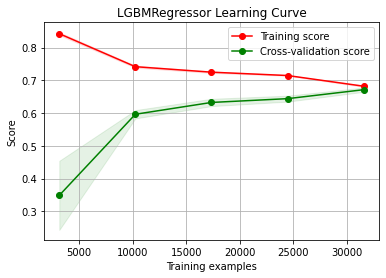

In [47]:
for model in models[2:]:
    plot_lear_curve(time_feats, model, kf, 'r2')

#### Extend original features with time based features

In [48]:
time_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability', 'pressure', 'temperature',
              'uvIndex', 'visibility', 'windBearing', 'windSpeed', 'icon_num', 'summary_num',
              'year', 'month', 'day', 'dayofyear', 'hour', 'weekday', 'IsWeekend',
              'Autumn', 'Spring', 'Summer', 'Winter']

In [49]:
for model in models:
    run_model(time_feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.5104, r2: 19.3%
RandomForestRegressor RMSE: 0.4925, r2: 25.1%
XGBRegressor RMSE: 0.4003, r2: 50.5%
LGBMRegressor RMSE: 0.3985, r2: 50.8%


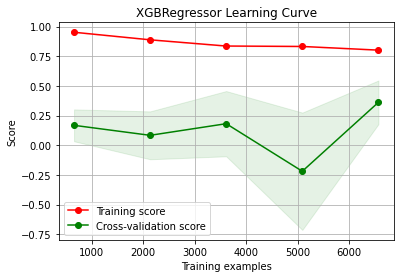

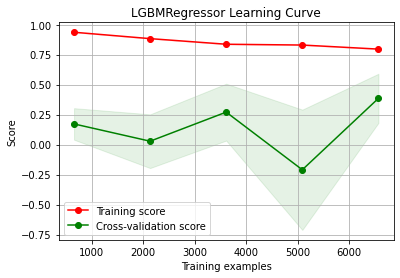

In [50]:
for model in models[2:]:
    plot_lear_curve(time_feats, model, tcsv, 'r2')

In [51]:
for model in models:
    run_model(time_feats, model, kf)

DecisionTreeRegressor RMSE: 0.4706, r2: 40.5%
RandomForestRegressor RMSE: 0.4644, r2: 42.1%
XGBRegressor RMSE: 0.3505, r2: 67.0%
LGBMRegressor RMSE: 0.3499, r2: 67.1%


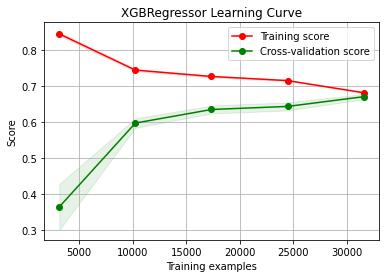

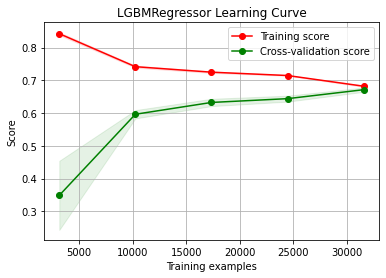

In [52]:
for model in models[2:]:
    plot_lear_curve(time_feats, model, kf, 'r2')

#### Quick check of XGBoost prediction errors

In [ ]:
X = df_train[orig_feats].values
y = df_train['PM25_nie_log'].values

X_test = df_test[orig_feats].values

model = xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', random_state=random_state)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

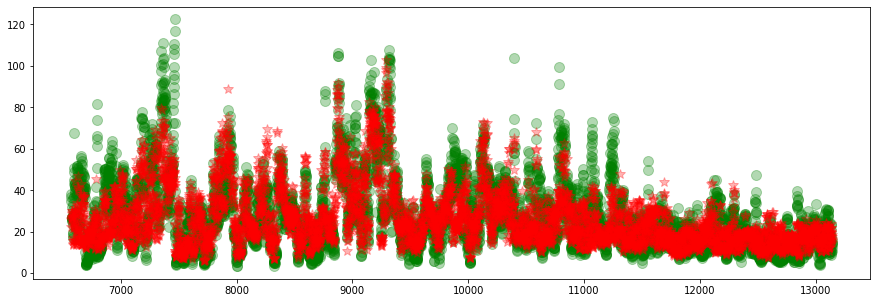

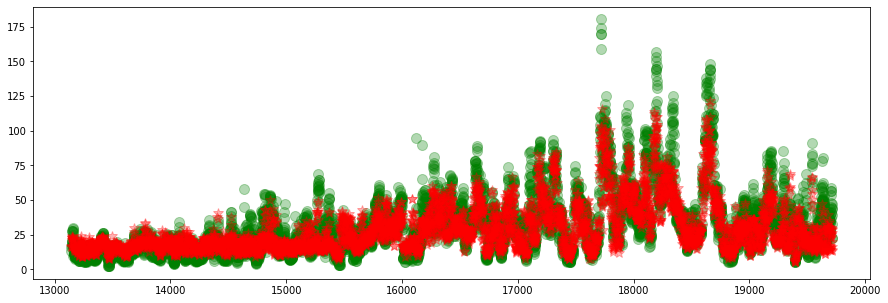

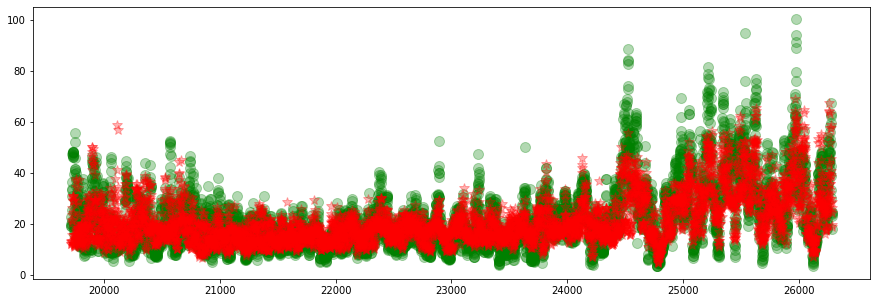

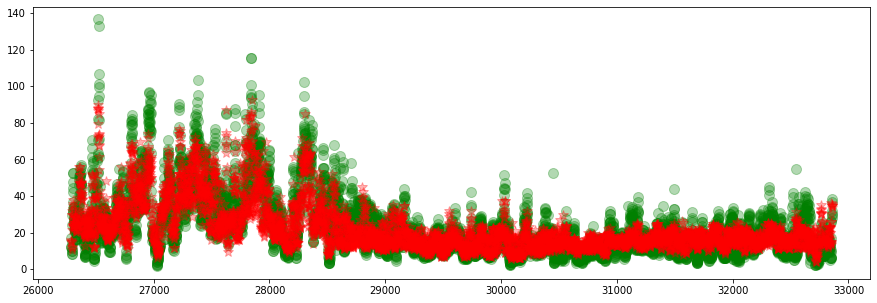

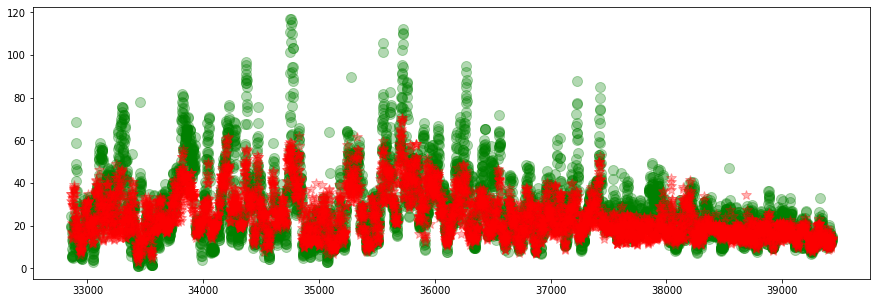

In [ ]:
for train_idx, test_idx in tcsv.split(y):
    train = y[train_idx]
    test = y[test_idx]
    y_log_pred = model.predict(X[test_idx])
        
    y_true = np.expm1(train)
    y_test = np.expm1(test)
    y_pred = np.expm1(y_log_pred)

    plt.figure(figsize=(15, 5))
    #plt.plot(train_idx, y_true, 'bo', alpha=0.3, ms=10, lw='3', label='train')
    plt.plot(test_idx, y_test, 'go',alpha=0.3, ms=10, lw='3', label='test')
    plt.plot(test_idx, y_pred, 'r*', alpha=0.3, ms=10, lw='3', label='forecast')

#### Select new features and run simple models

In [ ]:
# function to get all numerical features, except the one related to PM2.5 and Wokalna Street measures
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['PM25_nie', 'PM25_wok', 'PM25_nie_log', 'PM25_wok_log', 'PM25_nie_mean', 'PM25_wok_mean',
                  'PM25_nie_diff_for_day_median', 'PM25_nie_diff_for_day_mean', 'PM25_nie_diff_for_month_median', 'PM25_nie_diff_for_month_mean',
                  'PM25_wok_diff_for_day_median', 'PM25_wok_diff_for_day_mean', 'PM25_wok_diff_for_month_median', 'PM25_wok_diff_for_month_mean']
    return [x for x in feats if x not in black_list]

In [ ]:
#get feats
feats = get_feats(df_train)

In [ ]:
for model in models:
    run_model(feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.4377, r2: 41.3%
RandomForestRegressor RMSE: 0.4015, r2: 50.4%
XGBRegressor RMSE: 0.3588, r2: 60.0%
LGBMRegressor RMSE: 0.3615, r2: 59.3%


#### Check feature importance for XGB and LGBM

In [ ]:
# fit XGB model

X = df_train[feats].values
y = df_train['PM25_nie_log'].values

XGB_model = xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', random_state=random_state)
XGB_model.fit(X, y)

perm = PermutationImportance(XGB_model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=50)

Weight,Feature
0.2224 ± 0.0021,mean_PM25_nie_log_per_day
0.0476 ± 0.0012,windSpeed_rolling12h
0.0441 ± 0.0005,windSpeed_rolling24h
0.0392 ± 0.0009,dewPoint
0.0391 ± 0.0011,windSpeed_lag1h
0.0293 ± 0.0006,visibility
0.0248 ± 0.0009,humidity
0.0239 ± 0.0004,hour
0.0238 ± 0.0006,year
0.0213 ± 0.0010,dewPoint_rolling168h


In [ ]:
# fit LGBM model

X = df_train[feats].values
y = df_train['PM25_nie_log'].values

X_test = df_test[feats].values

LGBM_model = lgb.LGBMRegressor(max_depth=5, objective='regression', random_state=random_state)
LGBM_model.fit(X, y)

perm = PermutationImportance(LGBM_model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=50)

Weight,Feature
0.2260 ± 0.0037,mean_PM25_nie_log_per_day
0.0506 ± 0.0015,windSpeed_rolling12h
0.0457 ± 0.0014,windSpeed_rolling24h
0.0431 ± 0.0006,dewPoint
0.0367 ± 0.0012,windSpeed_lag1h
0.0273 ± 0.0004,visibility
0.0259 ± 0.0007,dewPoint_rolling168h
0.0252 ± 0.0010,humidity
0.0233 ± 0.0002,hour
0.0209 ± 0.0009,year


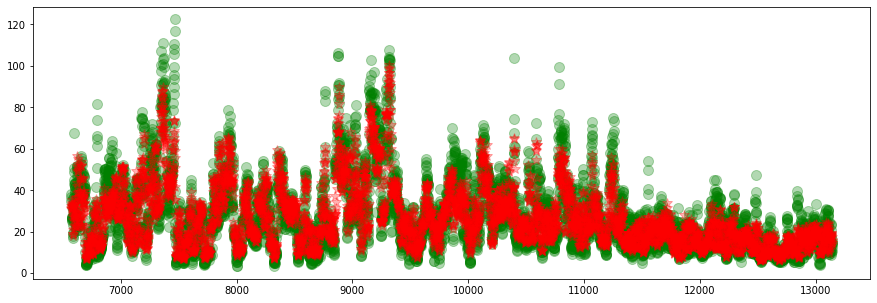

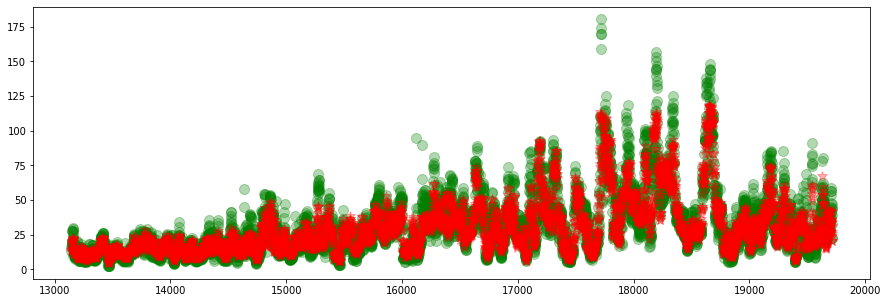

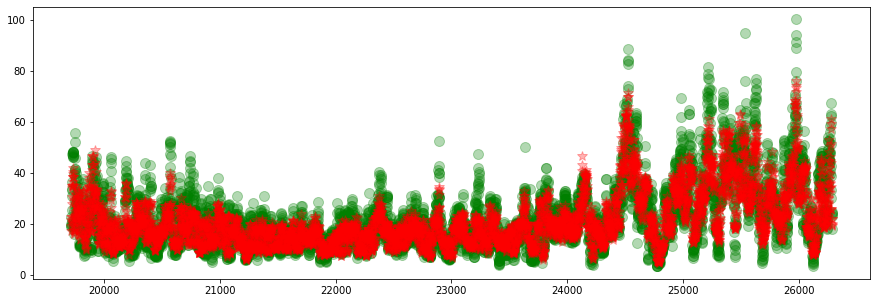

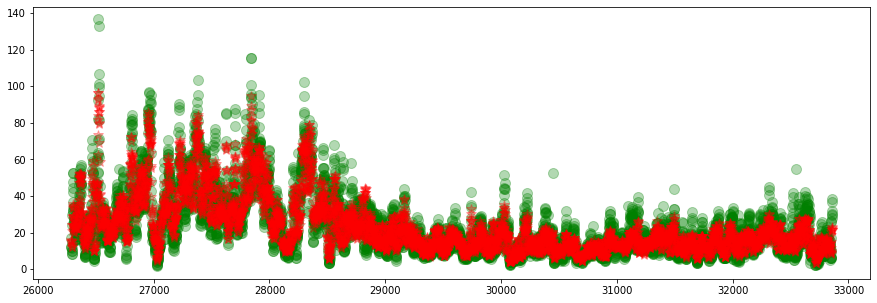

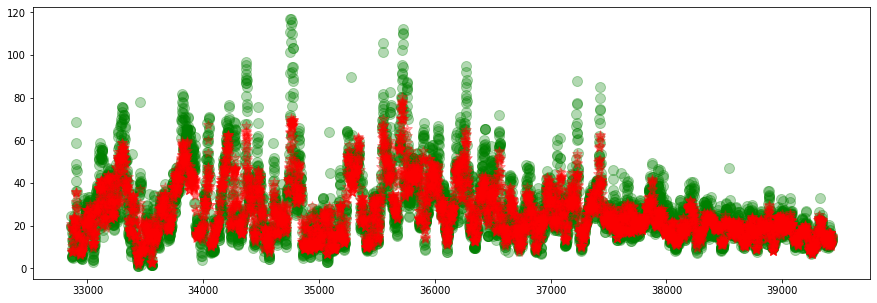

In [ ]:
for train_idx, test_idx in tcsv.split(y):
    train = y[train_idx]
    test = y[test_idx]
    y_log_pred = XGB_model.predict(X[test_idx])
        
    y_true = np.expm1(train)
    y_test = np.expm1(test)
    y_pred = np.expm1(y_log_pred)

    plt.figure(figsize=(15, 5))
    #plt.plot(train_idx, y_true, 'bo', alpha=0.3, ms=10, lw='3', label='train')
    plt.plot(test_idx, y_test, 'go',alpha=0.3, ms=10, lw='3', label='test')
    plt.plot(test_idx, y_pred, 'r*', alpha=0.3, ms=10, lw='3', label='forecast')

In [ ]:
features = [
            #'mean_PM25_nie_log_per_day',
            'mean_PM25_nie_per_day',
            'windBearing_rolling168h',
            'windBearing_lag1h',
            'windSpeed',
            'windSpeed_rolling12h',
            #'windSpeed_rolling24h',
            'windSpeed_lag1h',
            'dewPoint',
            'dewPoint_rolling168h',
            'visibility',
            'humidity',
            'humidity_lag1h',
            'year',
            'weekday',
            'hour',
            'temperature',
            'temperature_rolling12h',
            #'temperature_rolling168h',        
            'visibility_lag1h'
            ]

In [ ]:
XGB_model = xgb.XGBRegressor(max_depth=10, n_estimators=100, objective='reg:squarederror', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(max_depth=10, n_estimators=100, objective='regression', random_state=random_state)

In [ ]:
models = [XGB_model, LGBM_model]

for model in models:
    run_model(features, model, tcsv)

XGBRegressor RMSE: 0.3770, r2: 55.7%
LGBMRegressor RMSE: 0.3633, r2: 58.6%


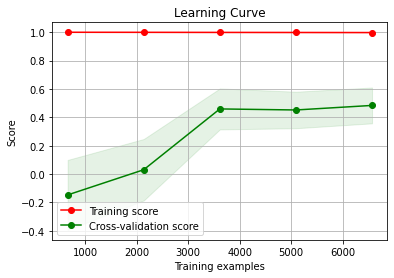

In [ ]:
def perform_scoring(y_true_log, y_log_pred):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_log_pred)
    return rmsle(y_true, y_pred)

scoring = make_scorer(perform_scoring, greater_is_better=False)

skplt.estimators.plot_learning_curve(XGB_model, X, y, cv=tcsv,scoring='r2');

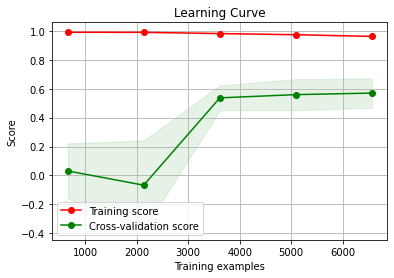

In [ ]:
skplt.estimators.plot_learning_curve(LGBM_model, X, y, cv=tcsv,scoring='r2')

In [ ]:
def objective(space):
    
    model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           random_state=2019
                           )
    
    def perform_scoring(y_true_log, y_log_pred):
        y_true = np.expm1(y_true_log)
        y_pred = np.expm1(y_log_pred)
    
        return rmsle(y_true, y_pred)
    
    for train_idx, test_idx in tcsv.split(X):

        eval_set  = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = model.predict(X[test_idx])

        score = perform_scoring(y[test_idx], y_pred)
    
        print("SCORE: {0}".format(score))
        return{'loss': 1-score, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 1000, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

SCORE: 0.40925188193339124
SCORE: 0.4053002027957436
SCORE: 0.4720018799418216
SCORE: 0.4251286584296546
SCORE: 0.44861256843495617
SCORE: 0.43382331681342395
SCORE: 0.4252452352930423
SCORE: 0.43535606991169357
SCORE: 0.3838334241656519
SCORE: 0.44192625087302234
100%|██████████| 10/10 [01:03<00:00,  6.38s/it, best loss: 0.5279981200581785]
The best params:  {'colsample_bytree': 0.5, 'gamma': 0.55, 'learning_rate': 0.47500000000000003, 'min_child': 5.0, 'n_estimators': 229, 'subsample': 0.7607214984484153, 'x_max_depth': 18.0}


In [ ]:
model = xgb.XGBRegressor(**best, objective='reg:squarederror', random_state=2019)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.55,
             importance_type='gain', learning_rate=0.47500000000000003,
             max_delta_step=0, max_depth=3, min_child=5.0, min_child_weight=1,
             missing=None, n_estimators=229, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=2019, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7607214984484153, verbosity=1, x_max_depth=18.0)

In [ ]:
perm = PermutationImportance(model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=50)

Weight,Feature
0.0841 ± 0.0009,dewPoint
0.0551 ± 0.0012,dewPoint_rolling168h
0.0545 ± 0.0009,mean_PM25_wok_log_per_day
0.0491 ± 0.0020,mean_PM25_wok_per_day
0.0464 ± 0.0010,temperature_rolling168h
0.0434 ± 0.0010,windSpeed_rolling12h
0.0389 ± 0.0004,windSpeed_rolling24h
0.0381 ± 0.0009,uvIndex_rolling168h
0.0381 ± 0.0017,windSpeed_log
0.0300 ± 0.0004,humidity


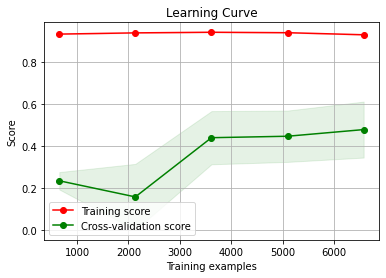

In [ ]:
skplt.estimators.plot_learning_curve(model, X, y, cv=tcsv,scoring='r2');

In [ ]:
feats = [	
         'dewPoint_rolling168h',
         #'mean_PM25_wok_log_per_day',
         #'mean_PM25_wok_per_day',
         'temperature_rolling168h',
         'windSpeed_rolling12h',
         'windSpeed_rolling24h',
         'uvIndex_rolling168h',
         'windSpeed_log',
         'humidity',
         'windSpeed_lag1h',
         'median_apparentTemperature_per_day',
         'hour',
         'windBearing_lag1h',
         'visibility_rolling168h',
         'year',
         'median_temperature_per_day',
         'visibility_lag1h',
         'windBearing_rolling168h',
         'mean_humidity_per_day',
         'visibility',
         #'mean_PM25_nie_log_per_day',
         'pressure_rolling168h',
         'dewPoint_rolling12h',
         'humidity_lag1h',
         'apparentTemperature',
         'cloudCover_rolling12h',
         'windSpeed',
         'pressure_rolling12h',
         'cloudCover_rolling24h',
         'dayofyear',
         'apparentTemperature_rolling168h',
         'pressure',
         'precipIntensity_rolling168h',
         'dewPoint_lag1h',
         'weekday'
         ]

In [ ]:
X = df_train[orig_feats].values
y = df_train['PM25_nie_log'].values

def objective(space):
    
    model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           random_state=2019
                           )
    
    def perform_scoring(y_true_log, y_log_pred):
        y_true = np.expm1(y_true_log)
        y_pred = np.expm1(y_log_pred)
    
        return rmsle(y_true, y_pred)
    
    for train_idx, test_idx in tcsv.split(X):

        eval_set  = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = model.predict(X[test_idx])

        score = perform_scoring(y[test_idx], y_pred)
    
        print("SCORE: {0}".format(score))
        return{'loss': 1-score, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 1000, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

SCORE: 0.454553749790929
SCORE: 0.462467321240064
SCORE: 0.5335128072754445
SCORE: 0.4487012848257228
SCORE: 0.4733501783684262
SCORE: 0.46780584655587415
SCORE: 0.5061286979002532
SCORE: 0.47047212998777654
SCORE: 0.4460719215876958
SCORE: 0.45812801783818724
100%|██████████| 10/10 [00:11<00:00,  1.19s/it, best loss: 0.4664871927245555]
The best params:  {'colsample_bytree': 0.55, 'gamma': 0.5, 'learning_rate': 0.47500000000000003, 'min_child': 1.0, 'n_estimators': 276, 'subsample': 0.7031746671704229, 'x_max_depth': 11.0}


In [ ]:
model = xgb.XGBRegressor(**best, objective='reg:squarederror', random_state=2019)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0.5,
             importance_type='gain', learning_rate=0.47500000000000003,
             max_delta_step=0, max_depth=3, min_child=1.0, min_child_weight=1,
             missing=None, n_estimators=276, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=2019, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7031746671704229, verbosity=1, x_max_depth=11.0)

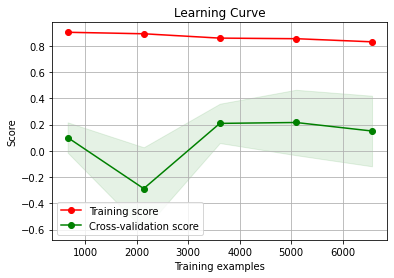

In [ ]:
skplt.estimators.plot_learning_curve(model, X, y, cv=tcsv,scoring='r2');

In [ ]:
run_model(orig_feats, model, tcsv)

XGBRegressor RMSE: 0.5159, r2: 9.0%
